In [1]:
!pip install catboost

     |████████████████████████████████| 66.3MB 56kB/s 


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')


Mounted at /content/drive


In [124]:
# df = pd.read_csv('/content/drive/MyDrive/ara_wat/res_df.csv')
df = pd.read_csv('data/res_df.csv')

In [125]:
df.head()

,Porosity,Resistivity,Water_Saturation
0,0.12529,6.52,1.0
1,0.14511,6.52,1.0
2,0.14511,6.52,1.0
3,0.13481,8.00,1.0
4,0.13481,8.00,1.0


In [280]:
#Crain's Method (1974)
#RW@75F = (400000 / 75 / WS) ^ 0.88
Rw_49F_35k = (400000/49/35000)**0.88  
Rw_160F_35k = (400000/160/35000)**0.88
Rw_49F_250k = (400000/7/250000)**0.88
Rw_160F_250k = (400000/160/250000)**0.88

print('Rw_49F_35k {}'.format(Rw_49F_35k))
print('Rw_160F_35k {}'.format(Rw_160F_35k))
print('Rw_49F_250k {}'.format(Rw_90F_250k))
print('Rw_160F_250k {}'.format(Rw_160F_250k))

Rw_49F_35k 0.27775402614580247
Rw_160F_35k 0.09804090886058128
Rw_49F_250k 0.028833155650137263
Rw_160F_250k 0.017378008287493755


In [ ]:
#Bateman and Konen Method (1977)
#RW@75F = 0.0123 + (3647.5 / WS^0.955)
#Rw_BK_49F_35k = (400000/49/35000)**0.88 

In [295]:
import random
random.seed(16) #12,close
a = random.uniform(0.8, 1.1)
m = random.uniform(1.6, 2.5)
n = random.uniform(1.7, 2.1)
rw = random.uniform(0.08, 0.12)

df['Archie_model_rand'] = ((a/(df['Porosity']**m))*(rw/df['Resistivity']))**(1/n) #randomization
df['Archie_model_sand_35'] = ((0.81/(df['Porosity']**1.7))*(Rw_49F_35k/df['Resistivity']))**(1/2.0) #sand
df['Archie_model_rocks_35'] = ((0.81/(df['Porosity']**1.7))*(Rw_49F_35k/df['Resistivity']))**(1/1.8) #rocks

#df['Archie_model_sand_250'] = ((0.81/(df['Porosity']**1.7))*(Rw_49F_250k/df['Resistivity']))**(1/2.0) #sand
#df['Archie_model_rocks_250'] = ((0.81/(df['Porosity']**1.7))*(Rw_49F_250k/df['Resistivity']))**(1/1.8) #rocks

df['Archie_model_rand'] = df['Archie_model_rand'].clip(0,1.0)
df['Archie_model_sand_35'] = df['Archie_model_sand_35'].clip(0,1.0)
df['Archie_model_rocks_35'] = df['Archie_model_rocks_35'].clip(0,1.0)

#df['Archie_model_sand_250'] = df['Archie_model_sand_250'].clip(0,1.0)
#df['Archie_model_rocks_250'] = df['Archie_model_rocks_250'].clip(0,1.0)

In [284]:
df.head()

,Porosity,Resistivity,Water_Saturation,Archie_model_sand_35,Archie_model_rocks_35,sand_diff_35,rock_diff_35,Archie_model_rand
0,0.12529,6.52,1.0,1.000000,1.000000,0.006839,0.007596,0.961455
1,0.14511,6.52,1.0,0.958310,0.953787,0.123391,0.136125,0.819386
2,0.14511,6.52,1.0,0.958310,0.953787,0.123391,0.136125,0.819386
3,0.13481,8.00,1.0,0.921009,0.912627,0.157512,0.173405,0.795627
4,0.13481,8.00,1.0,0.921009,0.912627,0.157512,0.173405,0.795627


In [285]:
#df['rand_diff'] = df['Water_Saturation'] - df['Archie_model_rand'] 
df['sand_diff_35'] = ((df['Water_Saturation'] - df['Archie_model_sand_35'] )**2)**0.5
df['rock_diff_35'] = ((df['Water_Saturation'] - df['Archie_model_rocks_35'] )**2)**0.5

#df['sand_diff_250'] = df['Water_Saturation'] - df['Archie_model_sand_250'] 
#df['rock_diff_250'] = df['Water_Saturation'] - df['Archie_model_rocks_250'] 

In [286]:
#print('Random_Model_diff - {}'.format(df['rand_diff'].sum()))
print('Sand_Model_diff - {}'.format(df['sand_diff_35'].mean()))
print('Rock_Model_diff - {}'.format(df['rock_diff_35'].mean()))

#print('Sand_Model_diff - {}'.format(df['sand_diff_250'].sum()))
#print('Rock_Model_diff - {}'.format(df['rock_diff_250'].sum()))

Sand_Model_diff - 0.22316570439842084
Rock_Model_diff - 0.23050688861266158


##### We ckeck best parameter of water resistivity depends of water salinity and TDS if we not know water Ionic Compostion.We arbitrary take TDS of 35 000 ppm instead.Find best temperature for the minumum error between Ws real and based on Archie equation. We found that temperature is about 49F

In [140]:
df.columns

Index(['Porosity', 'Resistivity', 'Water_Saturation', 'Archie_model_sand_35',
       'Archie_model_rocks_35', 'sand_diff_35', 'rock_diff_35',
       'Archie_model_rand'],
      dtype='object')

In [296]:
df_test  = df[['Porosity', 'Resistivity', 'Water_Saturation','Archie_model_sand_35','Archie_model_rocks_35','Archie_model_rand']]
df_test.head()

,Porosity,Resistivity,Water_Saturation,Archie_model_sand_35,Archie_model_rocks_35,Archie_model_rand
0,0.12529,6.52,1.0,1.000000,1.000000,0.961455
1,0.14511,6.52,1.0,0.958310,0.953787,0.819386
2,0.14511,6.52,1.0,0.958310,0.953787,0.819386
3,0.13481,8.00,1.0,0.921009,0.912627,0.795627
4,0.13481,8.00,1.0,0.921009,0.912627,0.795627


In [288]:
X = df_test.drop(['Water_Saturation'],axis=1)
Y = df['Water_Saturation']

In [289]:
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size = 0.1,random_state=77)

In [290]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.1,random_state=77) 


CatBoost Model.

In [297]:
cr = CatBoostRegressor(iterations=3000, learning_rate=0.13, depth=12, random_seed=77, loss_function='RMSE', eval_metric='RMSE',verbose=0)

In [298]:
np.mean(cross_val_score(cr, X_test, y_test, cv=3, scoring='r2',verbose=0))
cr.fit(X_train,y_train)

In [ ]:
#cr.fit(X_train,y_train)

In [299]:
pred_cat = cr.predict(X_test) # clipped 49F Archie models sand,rock,random, cv=3, 
mean_squared_error(y_test, pred_cat)

0.05269387404122507

In [300]:
pred_cat = cr.predict(X_val) # clipped 49F Archie models sand,rock,random, cv=3, 
mean_squared_error(y_val, pred_cat)

0.05288183928142254

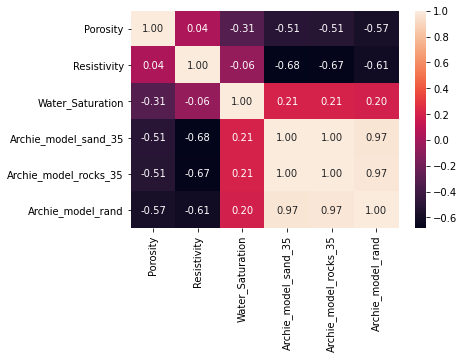

In [302]:
import seaborn as sns
Corr=df_test.corr()
sns.heatmap(Corr, annot=True, fmt='.2f')

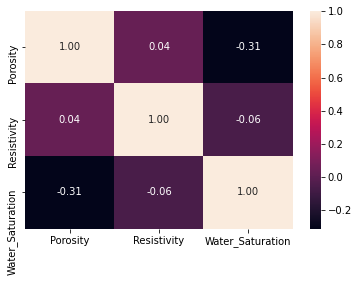

In [306]:
Corr=df_test[['Porosity', 'Resistivity', 'Water_Saturation']].corr()
sns.heatmap(Corr, annot=True, fmt='.2f')